## Quick Assessment of the expected values generated in SHAP production

Expected values generated from 100 randomly selected training examples




In [2]:
import tensorflow as tf
import shap
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

In [8]:
expected_values = np.load('expected_values.npy')
x_test = np.load('x_test_transformed.npy')
y_test = np.load('y_test_transformed.npy')

0.3572219


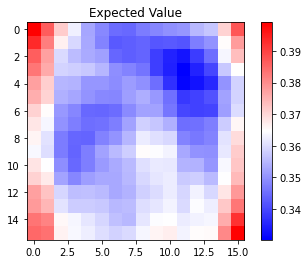

In [5]:
plt.imshow(expected_values, cmap='bwr')
plt.colorbar()
plt.title('Expected Value')
print(expected_values.mean())

## Comparing Mean Expected Value to Test Dataset

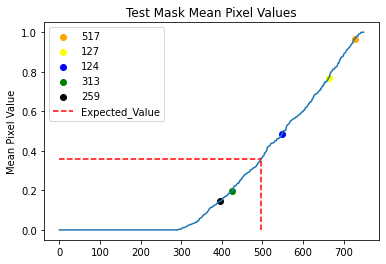

In [33]:
test_idx = [517, 127, 124, 313, 259]

# Find Mean of labels in test dataset
labels = np.mean(y_test, axis=(1, 2, 3))

ordered_labels = labels[labels.argsort()]
plt.plot(range(0, len(ordered_labels)), ordered_labels)
colors = ['orange', 'yellow', 'blue', 'green', 'black']
for i, idx in enumerate(test_idx):
    tmp_idx = np.where(labels.argsort() == idx)[0]
    plt.scatter(tmp_idx, ordered_labels[tmp_idx], label=idx, c=colors[i])
    
plt.hlines(expected_values.mean(), 0, np.argmin(abs(ordered_labels - expected_values.mean())),
           linestyles = 'dashed', color='red', label='Expected_Value')
plt.vlines(np.argmin(abs(ordered_labels - expected_values.mean())), 0, expected_values.mean(), 
          linestyles = 'dashed', color='red')
    
plt.ylabel('Mean Pixel Value')
plt.title('Test Mask Mean Pixel Values')
plt.legend()


## Shap Values

In [49]:
# Function for processing Shap Array
def get_channel_contributions(shap_values: np.ndarray) -> np.ndarray:

    n_pixels, n_samples, n_img_size, _, n_channels = shap_values.shape

    swaped_shap_values = np.swapaxes(shap_values, 0, 1)
    
    channel_contributions = []

    for sample_n in range(n_samples):
    
        sample = swaped_shap_values[sample_n]
        summed_contributions = sample.sum(axis=1).sum(axis=1)
        channel_contributions.append(
            summed_contributions.reshape(n_img_size, n_img_size, n_channels)
            )

    channel_contributions = np.array(channel_contributions)

    return channel_contributions

x_test = np.load('x_test_transformed.npy')[[517, 127, 124, 313, 259]]
y_test = np.load('y_test_transformed.npy')[[517, 127, 124, 313, 259]]

shap_values = np.load('shap_values_2.npy')
channel_contributions = get_channel_contributions(shap_values)


In [50]:
print(shap_values.shape)
print(channel_contributions.shape)

(256, 5, 16, 16, 4)
(5, 16, 16, 4)


In [53]:
def plot_maps(idx, figtitle=False, save=False):
    fig, axes = plt.subplots(2,4, figsize=(22, 10))

    for i, title in enumerate(['Seismic', 'Energy', 'Semblance', 'Edge Detection']):
        if i == 0:
            im = axes[0, i].imshow(x_test[idx, :, :, i], cmap='gray')
            axes[0, i].imshow(y_test[idx, :, :, 0], alpha=0.1, cmap='bwr')
        else:
            im = axes[0, i].imshow(x_test[idx, :, :, i], cmap='bwr')
        plt.colorbar(im, ax=axes[0, i])
        im = axes[1, i].imshow(channel_contributions[idx, :, :, i], cmap='bwr', vmin=-0.3, vmax=0.3)
        plt.colorbar(im, ax=axes[1, i])
        axes[0, i].set_title(title)
        axes[1, i].set_title(title + ' Contribution')
        if figtitle:
            fig.suptitle(figtitle)
        if save:
            fig.savefig(f'Chanel_Contribution_maps_idx{idx}')
    
def plot_hist(idx, figtitle=False, save=False):
    fig, axes = plt.subplots(1,2, figsize=(15, 5))
    axes[0].hist(channel_contributions[idx, :, :, 0].flatten(),
             range=(-0.5, 0.5), bins=50, fill=True, alpha=0.2, label='Seismic')
    axes[0].hist(channel_contributions[idx, :, :, 1].flatten(),
             range=(-0.5, 0.5), bins=50, fill=True, alpha=0.2, label='Energy')
    axes[0].hist(channel_contributions[idx, :, :, 2].flatten(),
             range=(-0.5, 0.5), bins=50, fill=True, alpha=0.2, label='Semblance')
    axes[0].hist(channel_contributions[idx, :, :, 3].flatten(),
             range=(-0.5, 0.5), bins=50, fill=True, alpha=0.2, label='Edge Detection')
    axes[0].legend()

    sns.kdeplot(channel_contributions[idx, :, :, 0].flatten(), fill=True, label='Seismic', ax=axes[1])
    sns.kdeplot(channel_contributions[idx, :, :, 1].flatten(), fill=True, label='Energy', ax=axes[1])
    sns.kdeplot(channel_contributions[idx, :, :, 2].flatten(), fill=True, label='Semblance', ax=axes[1])
    sns.kdeplot(channel_contributions[idx, :, :, 3].flatten(), fill=True, label='Edge Detection', ax=axes[1])
    axes[1].legend()
    axes[1].set_xlim(-0.5, 0.5)
    
    if figtitle:
        fig.suptitle(figtitle)
    if save:
        fig.savefig(f'Chanel_Contribution_histograms{idx}')
    

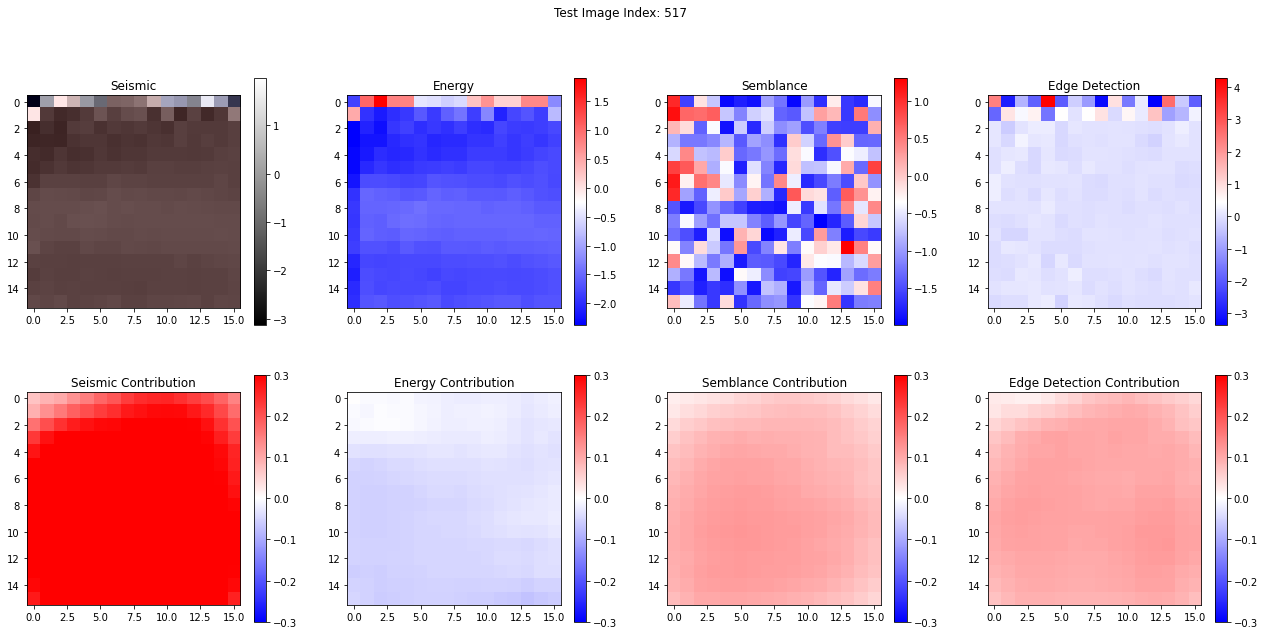

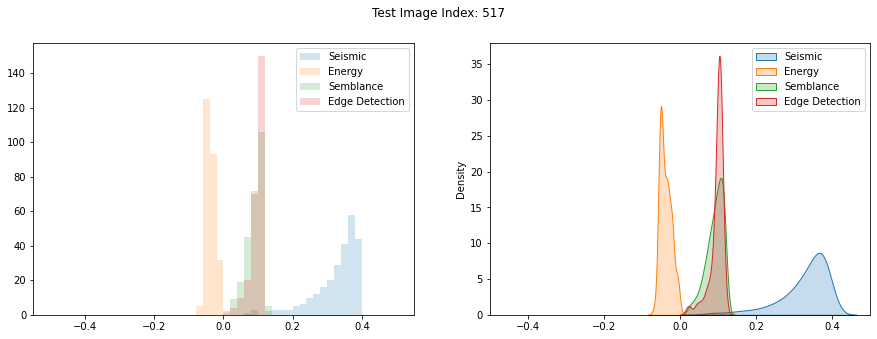

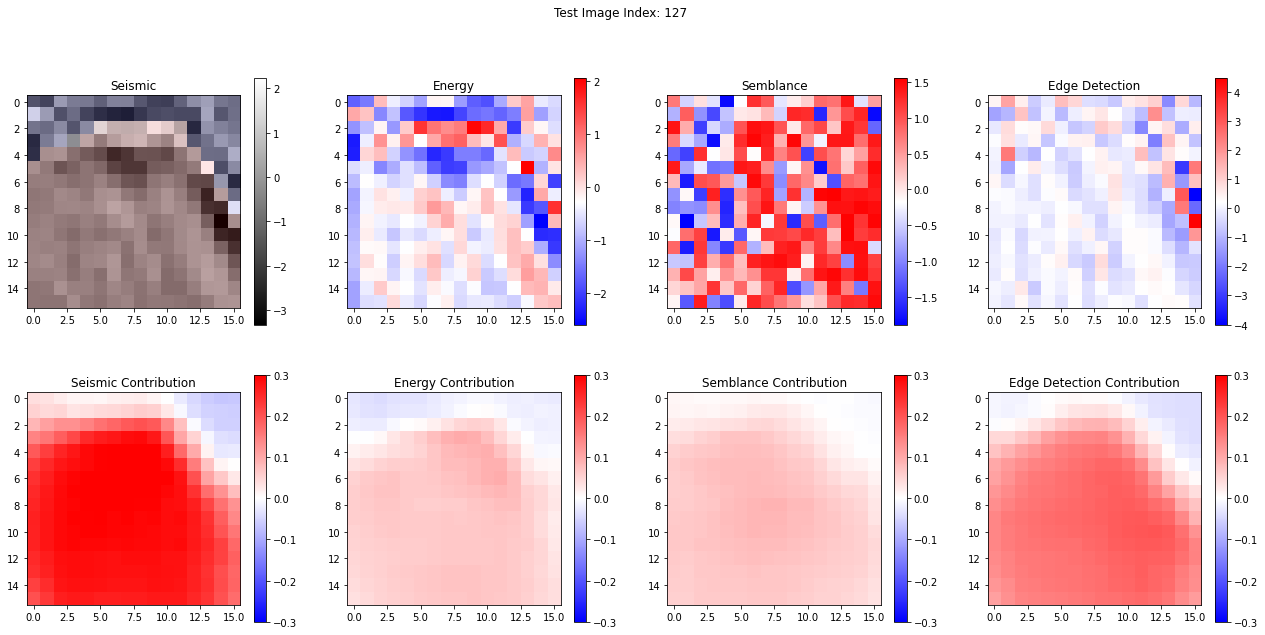

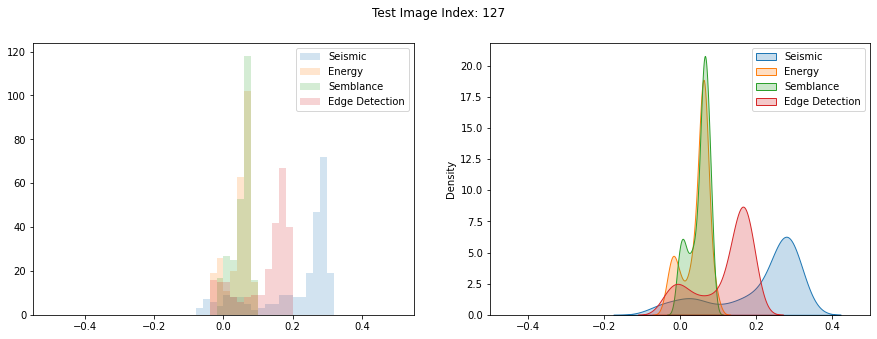

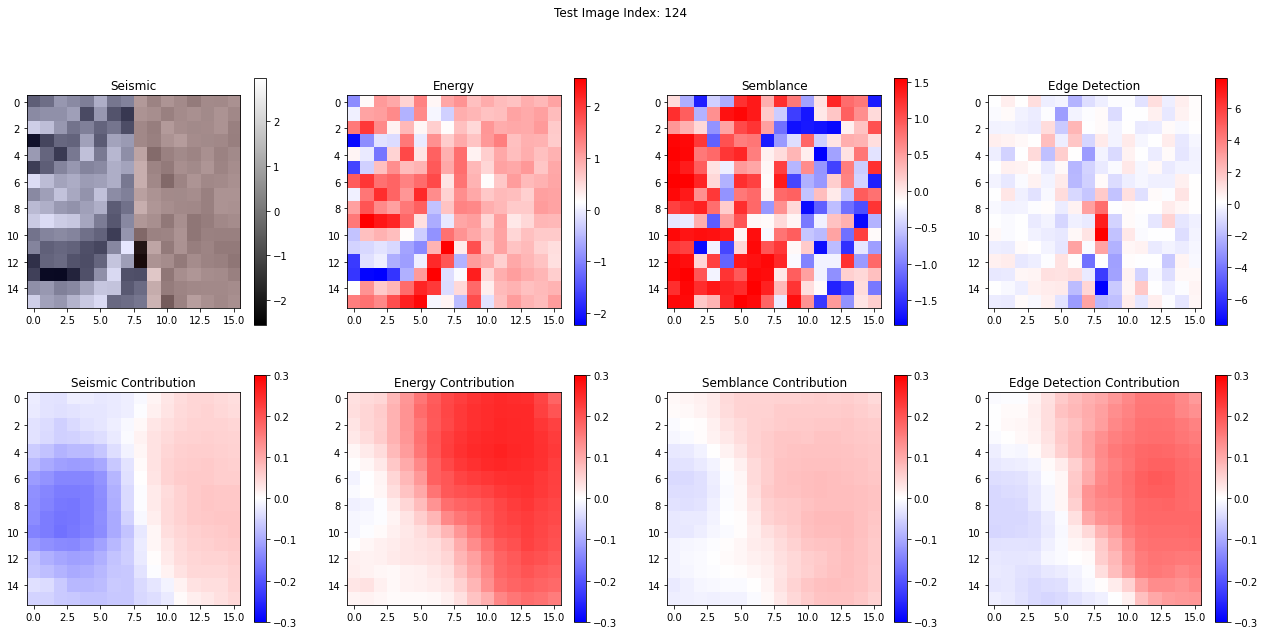

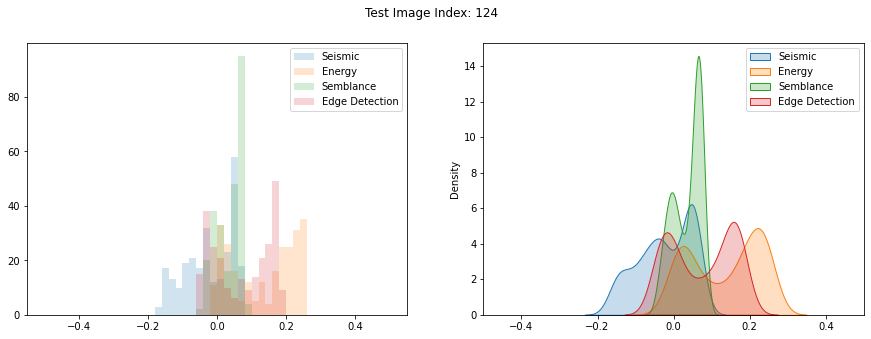

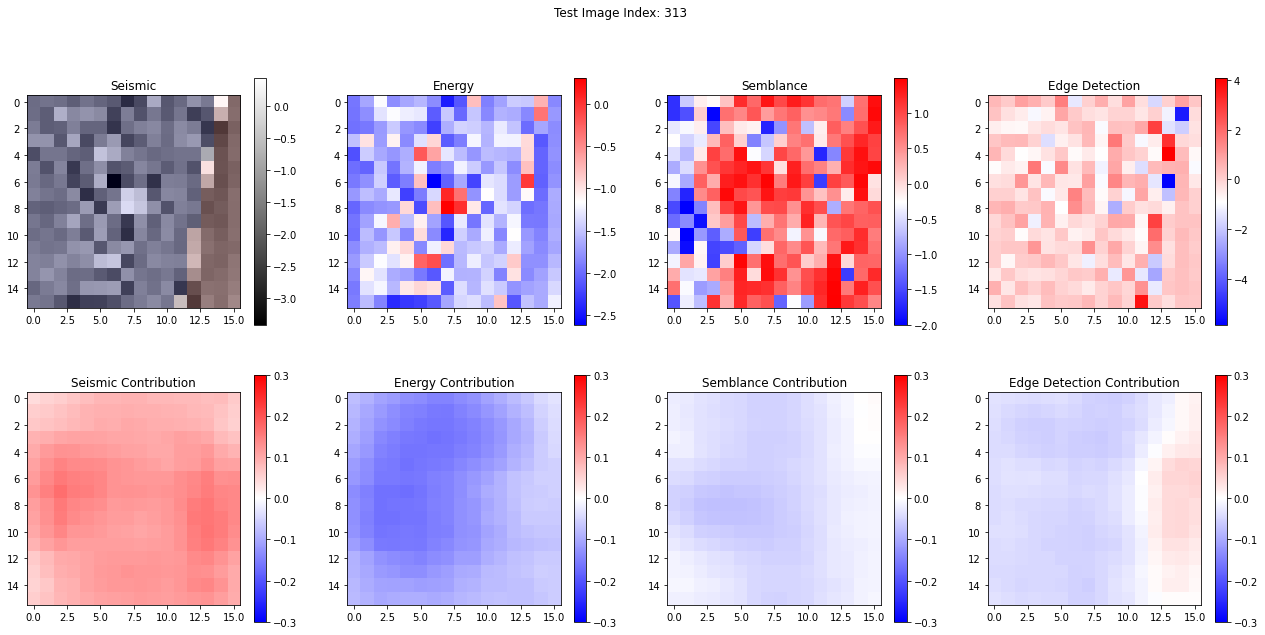

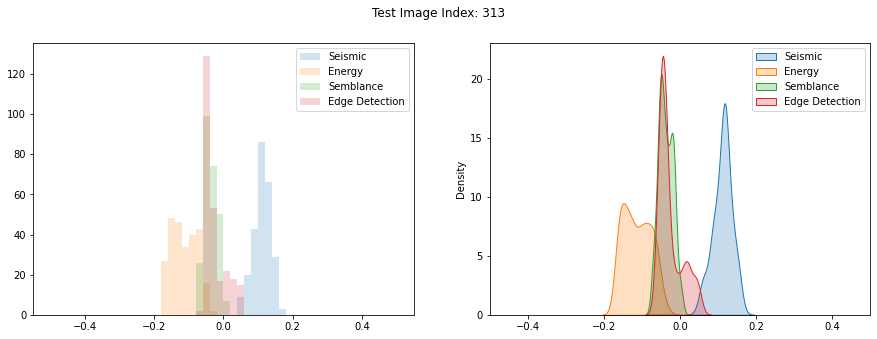

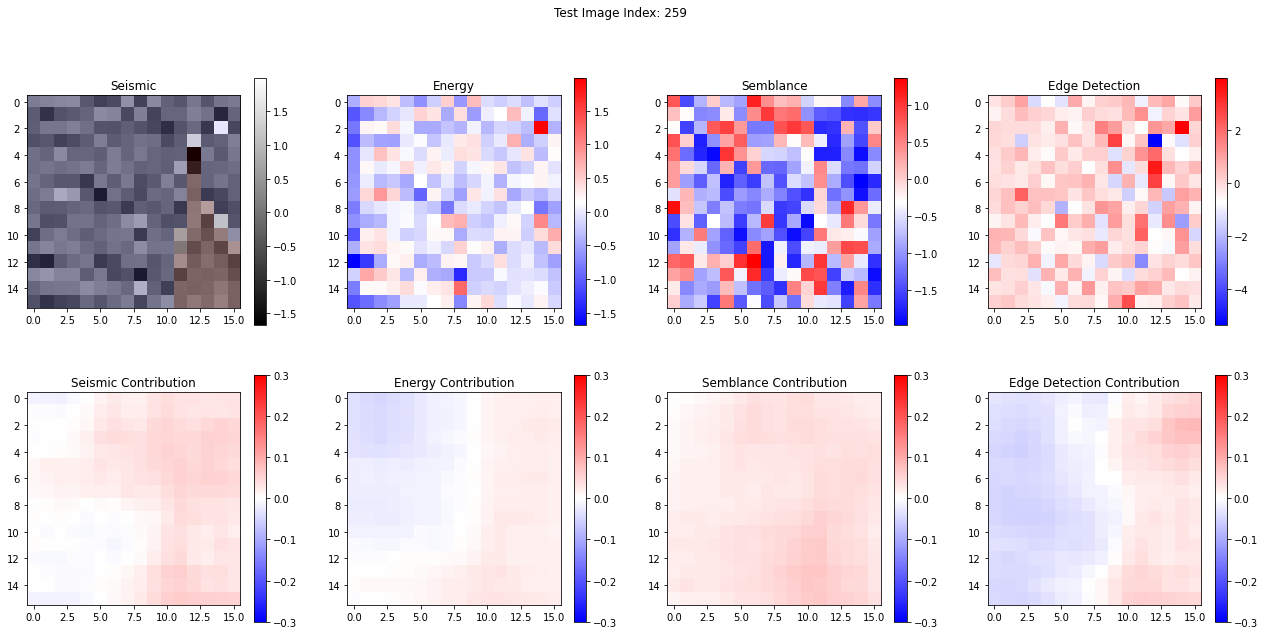

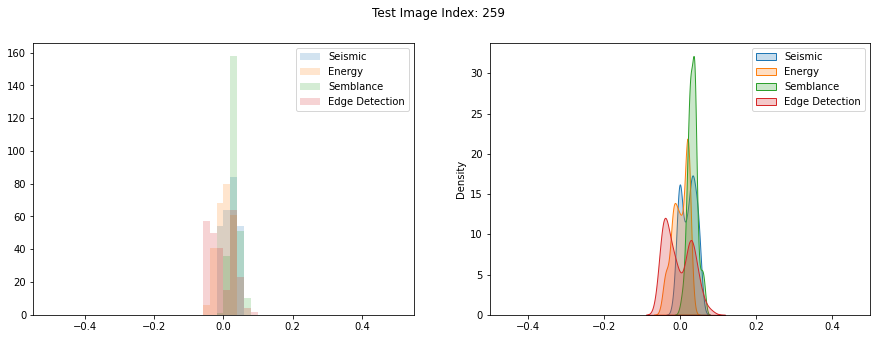

In [54]:
for i, idx in enumerate(test_idx):
    plot_maps(i, figtitle=f'Test Image Index: {idx}', save=True)
    plot_hist(i, figtitle=f'Test Image Index: {idx}', save=True)
